          위판일자         kg당가격
0     20130101  16857.928968
1     20130102  18898.236589
2     20130103  14804.943299
3     20130104  18638.359264
4     20130105  17328.816712
5     20130106  16740.322344
6     20130107  19150.684814
7     20130108  15507.950230
8     20130109  20033.880000
9     20130110  12798.030769
10    20130111  17438.743842
11    20130112  17471.017585
12    20130113  13598.027894
13    20130114  17384.658520
14    20130115  19729.419929
15    20130116  19232.866180
16    20130117  20827.720238
17    20130118  17611.444089
18    20130119  19590.683453
19    20130120  17427.838755
20    20130121  19751.508709
21    20130122  20506.572840
22    20130123  14243.568228
23    20130124  19852.802383
24    20130125  24663.632312
25    20130126  25190.064935
26    20130127  16342.627119
27    20130128  21965.043605
28    20130129  15382.409532
29    20130130  18716.121711
30    20130131  16866.955357
31    20130201  17483.457550
32    20130202  12798.506300
33    20130203

2017-01-23 00:00:00
2017-01-24 00:00:00
2017-01-25 00:00:00
2017-01-26 00:00:00
2017-01-27 00:00:00
2017-01-28 00:00:00
2017-01-29 00:00:00
2017-01-30 00:00:00
2017-01-31 00:00:00
2017-04-01 00:00:00
2017-04-02 00:00:00
2017-04-03 00:00:00
2017-04-04 00:00:00
2017-04-05 00:00:00
2017-04-06 00:00:00
2017-04-07 00:00:00
2017-04-08 00:00:00
2017-04-09 00:00:00
2017-04-10 00:00:00
2017-04-11 00:00:00
2017-04-12 00:00:00
2017-04-13 00:00:00
2017-04-14 00:00:00
2017-04-15 00:00:00
2017-04-16 00:00:00
2017-04-17 00:00:00
2017-04-18 00:00:00
2017-04-19 00:00:00
2017-04-20 00:00:00
2017-04-21 00:00:00
2017-04-22 00:00:00
2017-04-23 00:00:00
2017-04-24 00:00:00
2017-04-25 00:00:00
2017-04-26 00:00:00
2017-04-27 00:00:00
2017-04-28 00:00:00
2017-04-29 00:00:00
2017-04-30 00:00:00
2017-05-01 00:00:00
2017-05-02 00:00:00
2017-05-03 00:00:00
2017-05-04 00:00:00
2017-05-05 00:00:00
2017-05-06 00:00:00
2017-05-07 00:00:00
2017-05-08 00:00:00
2017-05-09 00:00:00
2017-05-10 00:00:00
2017-05-11 00:00:00


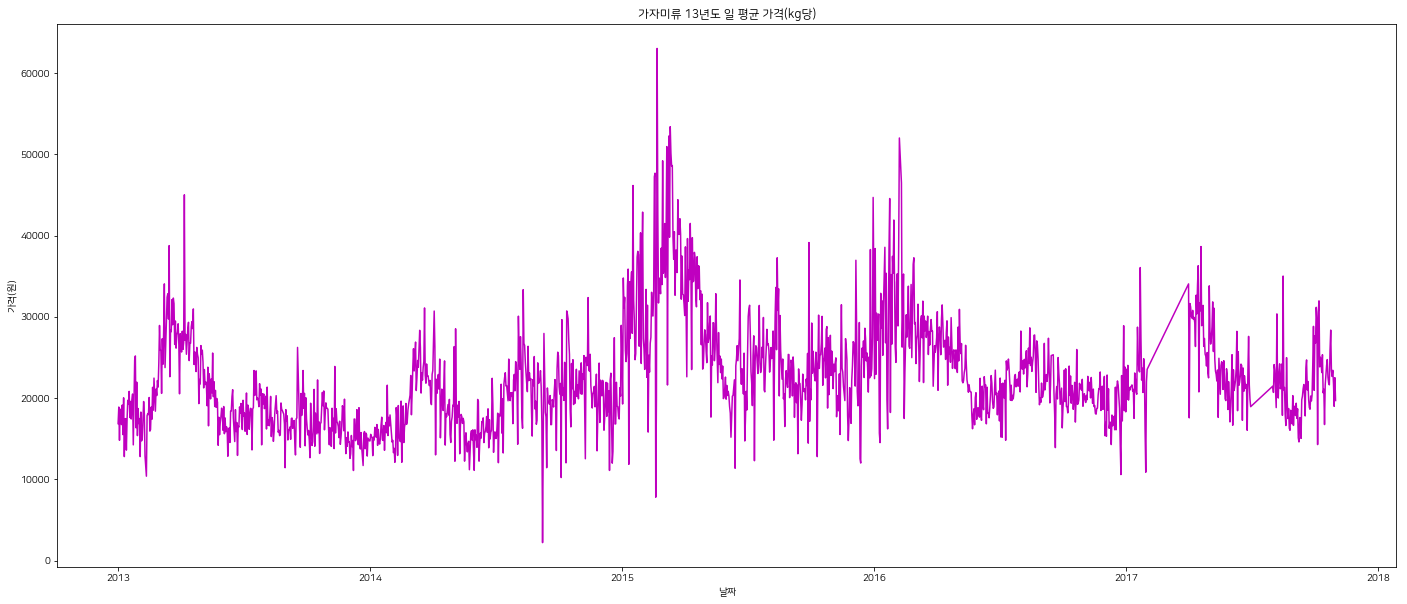

총 경과 시간 : 0.0122933030128479 분 


In [2]:
##################################### 메인 ########################################
from pandas import DataFrame
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
from matplotlib import pylab
import datetime as dt
import pandas as pd
import calendar
import time
from glob import glob
import sqlite3
import numpy as np

# db.sqlite3라는 데이터베이스 파일에 연결한다.
conn = sqlite3.connect("db.sqlite3")
# column : "위판일자","수산물표준코드명","산지조합명","위판중량", "위판금액","kg당가격"
# 샘플 : 가자미류에 대한 위판일자, 수산물표준코드명, kg당가격을 가져온다.
df = pd.read_sql_query("select 위판일자,수산물표준코드명,kg당가격 from price where 수산물표준코드명='가자미류'",conn)

%matplotlib inline

start_time = time.time()  # 시간측정시작


# 그룹별 평균을 구한다. 여기서는 위판일자별 kg당가격 평균
df_mean = df.groupby(['위판일자'], as_index=False).mean() 
print(df_mean.to_string())

###############################그래프 생성#########################################################
# 그래프 월별 색깔 지정 (10가지 색상)
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# 한글 폰트 지정
plt.rcParams["font.family"] = 'NanumSquareRound'
plt.rcParams["font.size"] = 10

# x,y좌표 라벨, 표 크기 지정
plt.figure(figsize=(24,10))
plt.xlabel('날짜')
plt.ylabel('가격(원)')

# [plot data] x좌표 : 날짜, y좌표 : 일 평균 가격
x,y = [],[]
for line in df_mean.위판일자:
    times = dt.datetime.strptime(str(line),'%Y%m%d')
    print(times)
    x.append(times)
for line in df_mean.kg당가격:
    y.append(line)
'''
#강조 구간
for i in range(1,13):
    span_start = dt.datetime(2013, i, 1)
    end_day = calendar.monthrange(2013, i)[1] # i월달의 마지막 일을 가져온다.
    span_end = dt.datetime(2013, i, end_day)
    plt.axvspan(span_start, span_end, facecolor=colors[i%10], alpha=0.5)
'''
plt.title("가자미류 13년도 일 평균 가격(kg당)")
plt.plot(x,y,linestyle='-',c="m" ,label="value")
plt.show()

print("총 경과 시간 : %s 분 " %((time.time() - start_time)/60))

# db연결 닫는다.
conn.close()

In [ ]:
############### 어종명을 데이터베이스의 fish 테이블에 저장하는 부분.  ###############
############### column : index,0  ###############
df_kind = df.loc[df.어종상태명=="(활)",["수산물표준코드명"]]
df_kind_group = df_kind.groupby(['수산물표준코드명'], as_index=False)
df_kind = pd.DataFrame() 
#어종명 추출 
def subkind(row):
    return row['수산물표준코드명'].values[0]
df_kind = df_kind_group.apply(subkind) 

# fish 테이블에 어종명에 대한 데이터프레임을 저장한다.
df_kind.to_sql('fish',conn,if_exists='append')


In [ ]:
######## 어종별 산지조합명을 데이터베이스의 place 테이블에 저장 ########
######## column : index, 수산물표준코드명, 산지조합명 ########
def subplace(row):
    return row
# 어종상태명이 '(활)' 인 row의 해당 속성 열을 가져온다.
df_hwal = df.loc[df.어종상태명=="(활)",["위판일자","수산물표준코드명","산지조합명","위판중량", "위판금액"]]
cnt=0
# 어종별 산지조합명 db에 저장
for fish_kind in df_kind:
    cnt+=1
    print("총 {0}개 어종 중 {1} 번째 '{2}' DB 저장중..".format(len(df_kind),cnt,fish_kind))
    #어종별 row 
    temp = df_hwal.loc[df.수산물표준코드명==fish_kind,["수산물표준코드명","산지조합명"]]
    temp = temp.groupby(['산지조합명'], as_index=False)
    temp = temp.apply(subplace)
    df_place = temp.drop_duplicates(subset=['산지조합명','수산물표준코드명'])
    
    # place 테이블에 어종별 산지조합명에 대한 데이터프레임을 저장한다.
    df_place.to_sql('place',conn,if_exists='append')

In [ ]:
###### price 테이블에 column : "위판일자","수산물표준코드명","산지조합명","위판중량", "위판금액"인  데이터프레임 저장하는 부분########
######################## csv파일 읽어오고 dataframe생성 #####################

start_time = time.time()  # 시간측정시작
df = pd.DataFrame()       # 비어있는 dataframe생성
folder = "./dataset/"     # dataset 폴더의 경로
file_list = glob(folder + '*.csv')  #dataset 폴더에 들어있는 csv 확장자 리스트를 전부 가져온다.
for file in file_list:             #csv파일들을 하나의 dataframe으로 연결
    count+=1
    print("{0}번째 파일 읽는중..".format(count))
    f = pd.read_csv(file, engine='python',error_bad_lines=False, warn_bad_lines=False)
    #concat 함수를 통해 프레임을 연결한다
    #sort=true지정은 프레임의 column이 일치 하지 않을 경우 NaN으로 채워서 합친다.
    df = pd.concat([df,f], sort=True)
    print("경과 시간 : %s 초 " %((time.time() - start_time)))
print("데이터프레임 연결까지 경과 시간 : %s 분 " %((time.time() - start_time)/60))

###############어종명 데이터프레임 저장 ###############
df_kind = df.loc[df.어종상태명=="(활)",["수산물표준코드명"]]
df_kind_group = df_kind.groupby(['수산물표준코드명'], as_index=False)
df_kind = pd.DataFrame() 
def subkind(row):
    return row['수산물표준코드명'].values[0]
df_kind = df_kind_group.apply(subkind) #어종 저장

def sublst(row):
        b = row['위판금액']
        a = row['위판중량']
        kg = int(round((b/a)))
        return kg
   
###############어종별 가격 db에 저장###########
cnt=0
#어종별로 for문을 순회한다.
for fish_kind in df_kind:
    cnt+=1
    print("총 {0}개 어종 중 {1} 번째 '{2}' DB 저장중..".format(len(df_kind),cnt,fish_kind))

    #어종상태명이 '(활)' 인 row의 해당 속성 열을 가져온다.
    df_hwal = df.loc[df.어종상태명=="(활)",["위판일자","수산물표준코드명","산지조합명","위판중량", "위판금액"]]
    #어종별 row 선택 해당 속성 열을 가져온다.
    df_temp = df_hwal.loc[df_hwal.수산물표준코드명==fish_kind,["위판일자","수산물표준코드명","산지조합명","위판중량", "위판금액"]]

    
    #열에 있는 데이터중에 0인 데이터를 지운다 . axis = 1 은 그 해당 행을 지우고
    #                                           axis = 0 은 그 해당 열을 지운다.
    #0 value를 포함한 행을 삭제한다
    #데이터의 갯수가 충분히 많으므로 0인 데이터를 뺴줘도 무관하다.
    #데이터의 갯수가 충분하지 않다면 행삭제를 고려할 것

    if True == df_temp.empty:
        print("'{0}' 존재하지 않음 건너뜀".format(fish_kind))
        continue
        
    df_temp.dropna(inplace=True)
    
    # "kg당가격"이라는 비어있는 column을 추가하고 위판금액을 위판중량으로 나눈 값을 저장
    # 해당 column의 데이터 type을 float type으로 바꿔준다.
    try:
        df_temp[['위판금액', '위판중량']] = df_temp[['위판금액', '위판중량']].astype(float)
    except TypeError as e:
        print(e)
    except ValueError as e:
        print(e)
    df_temp = df_temp[~(df_temp == 0).any(axis=1)]
    df_temp['kg당가격'] = df_temp.apply(sublst,axis=1)
  
    #일자별 위판별 KG당 가격으로 데이터 전처리
    #'kg당가격' calumun
    #해양수산데이터에서 KG당 가격을 제공하지만 해당 데이터가 확인중 불확실하다. 
    #따라서 전체 위판금액에서 위판중량을 나눠서 KG당 가격을 다시 구한다.

    #'kg당가격으로 이상치 탐지를 작업합니다.'


    #####################이상치제거 및 데이터 가공 부분#######################
    kp = 'kg당가격'

    df_temp.loc[df_temp.kg당가격 == 0, 'kg당가격'] = np.nan
    #0의 값이 들어있는 데이터를 Nan으로 치환(0값은 로그변환시 에러 발생한다.)

    df_temp.dropna(inplace=True)
    #dropna함수를 이용해 결측값이 포함된 행을 전체제거해준다.

    df_temp['Log_'+ kp] = np.log(df_temp[kp])
    #'Log_kg당가격'행'에 로그변환

    q75, q25 = np.percentile(df_temp.Log_kg당가격.dropna(), [75 ,25])
    iqr = q75 - q25

    min = q25 - (iqr*1.5)
    max = q75 + (iqr*1.5)
    #1.5를 곱해줘서 그 밖의 값은 이상치로 판단한다.

    kp = 'Log_kg당가격'

    df_temp['Outlier'] = 1

    df_temp.loc[df_temp[kp] < min, 'Outlier'] = 0
    df_temp.loc[df_temp[kp] > max, 'Outlier'] = 0

    df_temp.loc[df_temp.Outlier == 0, 'Outlier'] = np.nan
    #0의 값이 들어있는 데이터를 Nan으로 치환(0값은 로그변환시 에러 발생한다.)

    df_temp.dropna(inplace=True)
    #dropna함수를 이용해 결측값이 포함된 행을 전체제거해준다.

    del df_temp["Outlier"]
    #이상치판별 열 제거

    # price 테이블에 "위판일자","수산물표준코드명","산지조합명","위판중량", "위판금액"에 대한 데이터프레임 저장.
    df_temp.to_sql('price',conn,if_exists='append')